Some functions defined in DM detection around BH paper (Nickles):

In [257]:
import scipy.stats as st
import numpy as np
import random

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from math import isnan
from astropy import units as u
from astropy import constants as c

%matplotlib inline
import matplotlib.pyplot as plt

In [270]:
G        = c.G
m_1      = 10**4 * (u.solMass)      # solar mass of intermediate mass black hole


rho_sp   = 226 * (u.solMass/(u.parsec**3))              # solar mass / pc**3
gamma_sp = 2              # slope parameter


# r_in   = 5.906*10**7 * (u.meter)      # meters, ASSUMING gamma_sp = 7/3
r_in     = 1.914*10**-9 * (u.parsec)     # "Parsecs"

# r_sp   = 3.61324*10**16 * (u.meter)  # meters, ASSUMING gamma_sp = 7/3
r_sp     = 1.17097 * (u.parsec)         # "Parsecs"

In [221]:
def m_dm(r):
    m_dm = ((4*sc.pi*rho_sp*r_sp**gamma_sp)
            /(3-gamma_sp))*r**(3-gamma_sp)
    return m_dm

In [222]:
def m_enc(r):
        m_enc = (m_dm(r) - m_dm(r_in))
        return m_enc

In [223]:
def dark_matter_dist(r):
        rho_dm = rho_sp*(r_sp/r)**gamma_sp
        return rho_dm*r**2

Let's test out a few of these functions:

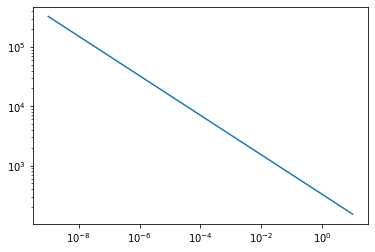

In [224]:
# Let's assort a logspace array of radii from r_in to r_sp limits, roughly.
radius  = np.logspace(-9,1,num=1000) * u.parsec


# # Calculate the DM mass for each radii.
# mass    = []
# for _ in radius:
#     mass.append(m_enc(_))
# m       = plt.figure(1)
# plt.loglog()
# plt.plot(radius,mass)

# And now for the dark-matter distribution:
density = dark_matter_dist(radius)
d       = plt.figure(2)
plt.loglog()

plt.plot((radius/u.parsec),(density*(u.parsec)/u.solMass))

Weighted Sampling from DM Density Function for radii:

In [225]:
def sample_cdf(pdf, xmin, xmax, n_bins=1000, log=False):
    if log:
        binner = np.geomspace
    else:
        binner = np.linspace
    edges = binner(xmin, xmax, n_bins)
    bins = np.vstack((edges[:-1], edges[1:])).T
    centers = np.mean(bins, axis=1)
    widths = bins[:, 1] - bins[:, 0]
    pdf_samples = pdf(centers)
    cdf_samples = np.cumsum(pdf_samples * widths)
    cdf_samples /= cdf_samples[-1]
    return np.vstack((centers, cdf_samples)).T

def inverse_CDF(*args, **kwargs):
    iy, ix = sample_cdf(*args, **kwargs).T
    return interp1d(ix, iy, fill_value='extrapolate')

def sample(icdf, n_samples):
    range_samples = np.random.uniform(size=n_samples)
    return icdf(range_samples)

In [226]:
%%time
def pdf(r):
    rho_dm = rho_sp*(r_sp/r)**gamma_sp
    return rho_dm*r**2
    
icdf = inverse_CDF(pdf, 10, 1e3)
samples = sample(icdf, 1000000)

Wall time: 161 ms


[772.21286745 450.83631604 168.20437244 923.37526686 215.58771606
 517.91572694 194.09534814  82.20828733 796.84318674  72.32686969]


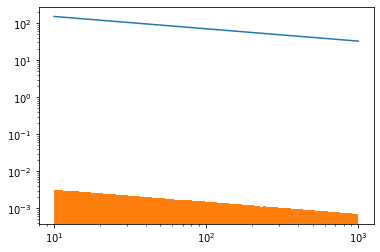

In [227]:
plt.loglog()
x = np.geomspace(10, 1e3, 100)
plt.plot(x, pdf(x))
plt.hist(samples, density=True, bins=np.geomspace(10, 1e3, 100));

samples = sample(icdf, 10)
print(samples)

Randomized cartesian coordinates for spherical DM halo:

In [228]:
def inverse_cdf(F):
    r = (r_sp**(-gamma_sp)*
         (F*r_sp**3+r_in**3*(r_sp/r_in)**gamma_sp-F*r_in**3*(r_sp/r_in)**gamma_sp))**(1/(3-gamma_sp))
    return r

In [229]:
def random_radius(sample):
    F = np.random.uniform(size=sample)
    return inverse_cdf(F)


In [230]:
def random_vector():
    vector            = np.asarray([np.random.normal() for _ in range(3)])
    normalized_vector = vector / np.linalg.norm(vector)
#     return normalized_vector[np.newaxis,:] * random_radius(sample)[:,np.newaxis]
    rand = random_radius(1)[0]
    return normalized_vector * random_radius(1)[0]


In [231]:
vector = []
for i in range(3):
    vector.append(random_vector())
print(vector)


[<Quantity [ 0.28569526, -0.26766252,  0.27404715] pc>, <Quantity [-0.34085715,  0.25533444, -0.18781716] pc>, <Quantity [-0.08847862, -0.00275482,  0.05531826] pc>]


Vector: [-0.17865832  0.24292025  0.23411961] pc


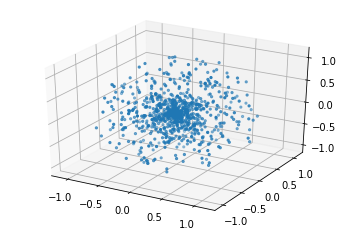

In [233]:
example_vector = random_vector()
print('Vector:', example_vector)

zdata = []
ydata = []
xdata = []

vectors = []
for i in range(1000):
    vectors.append(random_vector())
# print(vector)

for vector in vectors:
    xdata.append(vector[0]/u.parsec)
    ydata.append(vector[1]/u.parsec)
    zdata.append(vector[2]/u.parsec)

    
ax = plt.axes(projection='3d')
ax.scatter3D(xdata,ydata,zdata,s=5);

Let's randomize the velocities of each DM particle!

Here, we take our N(E) function, eq. (4.4), and plot it:
This defines the number of particles (y-axis) with an associated energy (x-axis).

In [259]:
from math import *

# Equation for N(E) as calculated using Mathematica.

def number_per_energy(epsilon):
    num_particles =                                                \
    (G**3)*(sc.pi**(3/2))*(epsilon**(gamma_sp-4))*(m_1**3)         \
    *((r_sp/(G*m_1))**gamma_sp)*(gamma_sp-1)*(gamma_sp)*(rho_sp)   \
    *gamma(gamma_sp-1)
    
    num_particles = num_particles / (gamma(gamma_sp-(1/2)))
    return num_particles


In [316]:
print(unit_energy)
# Off by a factor of kg**(1/3)?
print(G)
number_per_energy(unit_energy).decompose()

pc2 solMass / s2
  Name   = Gravitational constant
  Value  = 6.6743e-11
  Uncertainty  = 1.5e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2018


<Quantity 9.29100809e-86 s2 / (kg m2)>

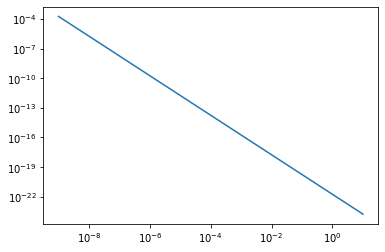

In [274]:
unit_energy = (u.solMass*u.parsec**2*u.s**-2)


energies   = np.logspace(-9,1,num=100) * unit_energy
# print(r_in)
# print(r_sp)
num_energy = []
for dE in energies:
    num_energy.append(number_per_energy(dE)*unit_energy)
plt.loglog()
plt.plot(energies/unit_energy,num_energy)


Then, we must normalize our function over some epsilon_min to +inf. 
Using Mathematica, we find the following expression!

In [281]:

def norm_energy(epsilon_min,epsilon_max):
    normFinal =                                          \
    (G**3)*(sc.pi**(3/2))*(m_1**3)                       \
    *((r_sp/(G*m_1))**gamma_sp)*(gamma_sp-1)*(gamma_sp)  \
    *((-epsilon_max**(gamma_sp))*(epsilon_min**3)        \
    +(epsilon_max**3)*epsilon_min**(gamma_sp))*(rho_sp)  \
    *gamma(gamma_sp-1)
    
    normFinal /= ((gamma_sp-3)*(gamma(gamma_sp-(1/2))))*(epsilon_max**3)*(epsilon_min**3)
    return normFinal

# Re calculate from -inf to e_min
# Okay, we did that: all that changes is the sign of the output!
                                               

In [289]:
epsilon_unit = (u.solMass/u.parsec)*(u.meter**3/(u.kg*u.second**2))

epsilon_min = (G*m_1)/(10*r_sp)
# Some outer radius threshold, we define to be ~10*r_sp.
epsilon_max = (G*m_1)/(10*r_in)
# Some inner radius threshold, we define to be ~10*r_in????

norm = norm_energy(epsilon_min,epsilon_max)
# We define new N(E) function / norm

print(norm)

-45599.03044368055 solMass


We need to randomly sample energy for a given particle based on the energy functions above.

In [291]:
%%time
# Then, to sample random energies, we refer to the previously-done exercise.

# Our N(E) function, normalized.
def norm_num_per_energy(e):
    num = number_per_energy(e)/norm
    return num
    
icdf = inverse_CDF(norm_num_per_energy, epsilon_min/epsilon_unit, epsilon_max/epsilon_unit)
samples = sample(icdf, 8)
print(samples)

def random_energy(num):
    samples = sample(icdf, num)
    return samples * unit_energy


[-0.16212826 -0.05790522 -0.27038303 -0.26809249 -0.12496017  0.1028429
 -0.22296493 -0.25702568]
Wall time: 5 ms


Here, we quickly generate a random set of unit vectors for the velocity's direction:

In [292]:
# This is very similar to the previous function for generating random vectors, but without the random radius.
def random_unit_vector(num):
    arr = np.random.normal(size=num*3).reshape((num,3))
    arr /= np.linalg.norm(arr,axis=1)[:,np.newaxis]
    return arr


In [293]:
%%time
# Test creating num amount of random unit vectors.

num = 10000
r = np.random.normal(size=num*3).reshape((num,3))
r /= np.linalg.norm(r,axis=1)[:,np.newaxis]


Wall time: 2 ms


In [294]:
%%time
# Then, we compare the previous method with for loops and the timing.

points = []
for i in range(num):
    r = np.asarray([np.random.normal() for j in range(3)])
    r /= np.linalg.norm(r)
    points.append(r)

    

Wall time: 378 ms


In [295]:
random_unit_vector(num=1)

array([[0.70228349, 0.46411798, 0.53980775]])

In [310]:
# Here's the gravitational potential as defined in the paper.
# SHOULD IT BE NEGATIVE SINCE ATTRACTIVE?
m_2 = 1*u.solMass


def grav_potential(r):
    psi = (G*m_1*m_2)/(r) * u.parsec**-1
    return -psi

# We obtain the velocity through another equation defined in the paper (4.1)
def rand_velocity(r,**kwargs):
    e = kwargs.get('e', None)
    if (e):
        magnitude = (2*(grav_potential(r)-e))**(1/2)
        return magnitude
    else:
        randE = random_energy(1)[0]
        magnitude = (2*(grav_potential(r)-randE))**(1/2)
        return magnitude, randE


In [311]:
def rand_vect_gen(num):
    for i in range(num):
        cartesian = random_vector()                # Generate num amount of position vectors, save the radius.
        positions[i,:] = (cartesian)               # We append the (x,y,z) coord's to our position list.
    radii = np.linalg.norm(positions,axis=1)
    return positions,radii

In [312]:
# What kind of magnitudes are we looking at for the gravitational potential VS the random energy?
print('gravitational potential',grav_potential(0.22195426))
print('random energy: ',random_energy(1)[0])


gravitational potential -3.0070610043709005e-06 m3 solMass2 / (kg pc s2)
random energy:  -0.01270513236261072 pc2 solMass / s2


Then, for some number of particles, we generate a velocity direction and magnitude:

In [315]:
%%time
# Number of particles to generate positions and velocity vectors for.
num = 10

# We initialize lists for position vectors and a list of respective radii generated from previous functions.
positions = np.zeros((num,3))

positions,radii = rand_vect_gen(num)
    
# print(positions, '\n')
print(radii, '\n')

velocities = random_unit_vector(num)                 # Generate some num amount of velocity unit vectors.
# print(velocities, '\n')

complexList = np.zeros((num,3))
energyList = np.zeros((num,1))

# Set an arbitrary indexing counter, i.
for i, particle in enumerate(velocities):
    r             = radii[i]                         # We find the corresponding radius for our i'th particle.
    magnitude, energy = rand_velocity(r)
    energyList[i,:]  = (energy)

    particle_new  = particle * magnitude             # Update the particle's velocity vector.
    if isnan(particle_new[0]):
        # We identify the particles with complex velocities.
        complexList[i,:] = (particle)
        
        
    velocities[i] = particle_new                     # Set the i'th velocities vector to this updated vector.
    
    
# Now, we should have a list of velocity vectors with random direction and magnitude based on energies->radii/pos.

print(velocities)
# print(positions)

i = 0
for item in velocities:
    if isnan(item[0]):
        i += 1
print('\nThere are ',i,'cases where the velocity is NaN!\n')
print('This means: ',(i/num)*100,'% of the particles generated could not have a velocity.\n')

print(complexList)
print(energyList)
# Only NaN when the energy is a positive value?????




[0.4092832  0.23890289 1.06543828 0.80949539 0.52196963 1.14184054
 0.59739455 0.00381037 1.03791937 1.16768057] 



C:\Users\ENG\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


UnitConversionError: 'm(3/2) solMass / (kg(1/2) pc(1/2) s)' and 's2 / (pc2 solMass)' are not convertible

In [28]:
20 * u.parsec + 10**100 * u.meter

<Quantity 3.24077929e+83 pc>